In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [2]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

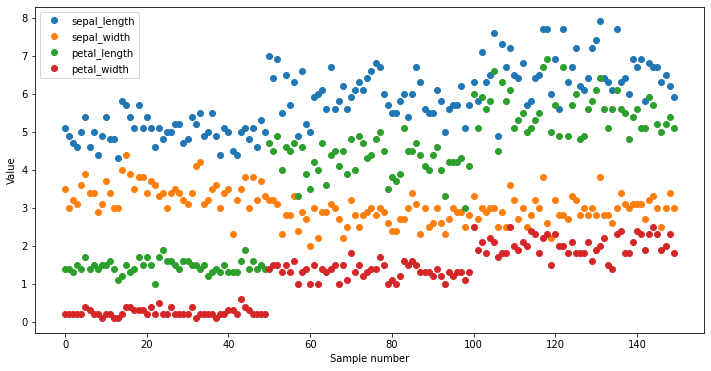

In [3]:
#plot the data
iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [4]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

# Break the data into batches

In [7]:
#use sckit-learn to split the data
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=.2)

#then convert them into pytorch datasets (already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)

#finally, translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])


In [8]:
#check sizes of data batches
for X,y in train_loader:
    print(X.shape,y.shape)




torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])


# Construct the model and training plan

In [9]:
# a function that creates the ANN model

def createANewModel():
    #model architecture
    ANNiris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3),

    )
    #loss fun
    lossfun = nn.CrossEntropyLoss()

    #optimizer 
    optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.0005)
    return ANNiris,lossfun,optimizer

    


In [10]:
#TRAIN THE MODEL

#global parameter
numepochs = 2500

def trainTheModel():
    #initialize accuracies as empties
    trainAcc = []
    testAcc = []
    losses = []

    #loop over epochs
    for epochi in range(numepochs):
        
        #loop over training data batches
        batchAcc = []
        batchLoss = []

        for X,y in train_loader:
            # forward pass and loss
            yHat = ANNiris(X)
            loss = lossfun(yHat,y)

            #back prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #compute training accuracy just for this batch
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())

            batchLoss.append(loss.item())

            #end 0f batch loop
            # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )
        losses.append( np.mean(batchLoss) )

         # test accuracy
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        predlabels = torch.argmax( ANNiris(X),axis=1 )
        testAcc.append( 100*torch.mean((predlabels == y).float()).item() )
  
        # function output
    return trainAcc,testAcc,losses


# Test the model

In [11]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
trainAcc,testAcc,losses = trainTheModel()

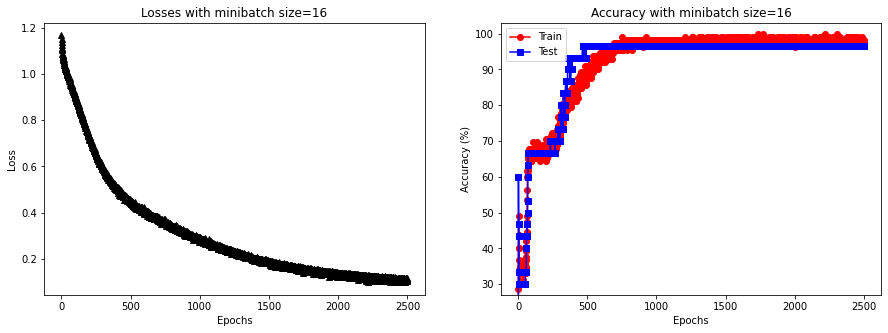

In [12]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with minibatch size=' + str(batchsize))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with minibatch size=' + str(batchsize))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
ax[1].set_ylim([27,103])

plt.show()